In [68]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

# Machine Learning - Model Selection and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_curve, auc, 
                           roc_auc_score, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay)

# Data preprocessing and utilities
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.utils import resample

# Imbalanced data handling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Statistical analysis
from scipy.stats import ttest_ind

# System utilities
import os

# Import dataset

In [69]:

df = pd.read_csv('/Users/victoriayuzova/Data-Science-Projects/Fraud Detection/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Explore dataset

Checking some basic things:
- if there are nulls,
- if there any interesting correlations between variables

In [70]:
# all the variables are numeric, no need to worry about preprocessing categorical vars
# no need to worry about nulls (some algoritms dont tolerate them)
# good number of records
# time and amount variables are the only variables not encrypted

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [71]:
# dont see much here, but since these are numeric, let´s plot some correlations and cehck distributions of variables

df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

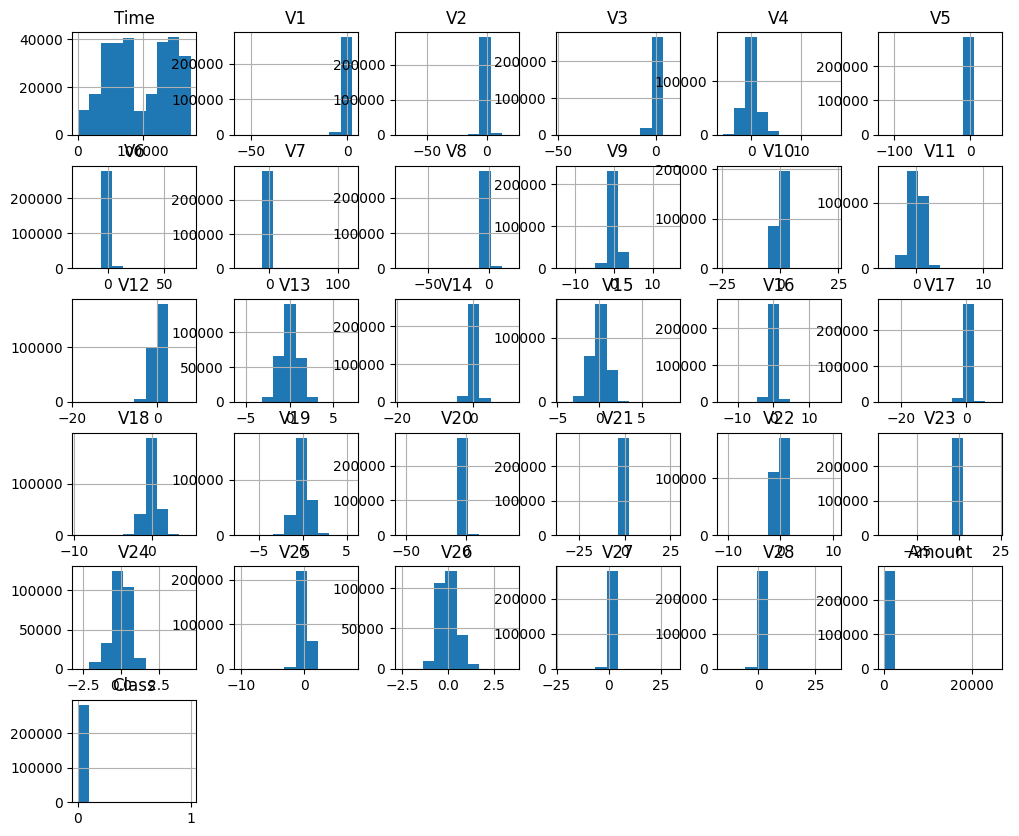

In [72]:
df.hist(figsize=(12, 10))

# time is bimodal
# here I see that some variables are skewed or have outliers; anomalies are likely signals of fraud

# not sure though what I can do about any of those distributions; further I will be tranforming them with StandardScaler

In [73]:
# the dataset is imbalanced

df['Class'].value_counts(normalize = True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

/var/folders/6t/ss4jn8_x3bx5gzn4fh3r10g00000gn/T/ipykernel_1319/2032563797.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('time_bin')['Class'].mean().reset_index().plot(
/var/folders/6t/ss4jn8_x3bx5gzn4fh3r10g00000gn/T/ipykernel_1319/2032563797.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['Class'] == 1].groupby('time_bin')['Class'].count().reset_index().plot(


<Axes: title={'center': 'Fraud Rate (count) Over Time'}, xlabel='time_bin'>

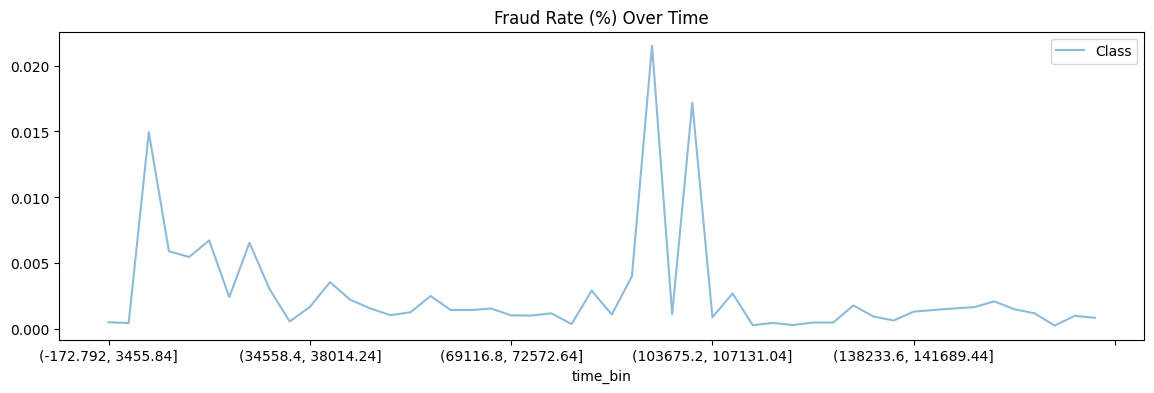

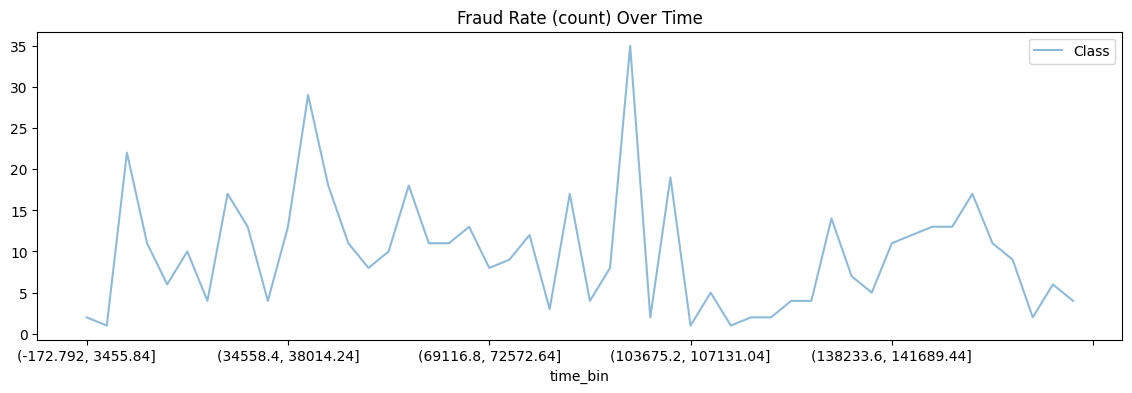

In [74]:
df['time_bin'] = pd.cut(df['Time'], bins=50)


df.groupby('time_bin')['Class'].mean().reset_index().plot(
    x='time_bin', y='Class', kind='line', figsize=(14, 4), alpha=0.5, title='Fraud Rate (%) Over Time'
)

df[df['Class'] == 1].groupby('time_bin')['Class'].count().reset_index().plot(
    x='time_bin', y='Class', kind='line', figsize=(14, 4), alpha=0.5, title='Fraud Rate (count) Over Time'
)

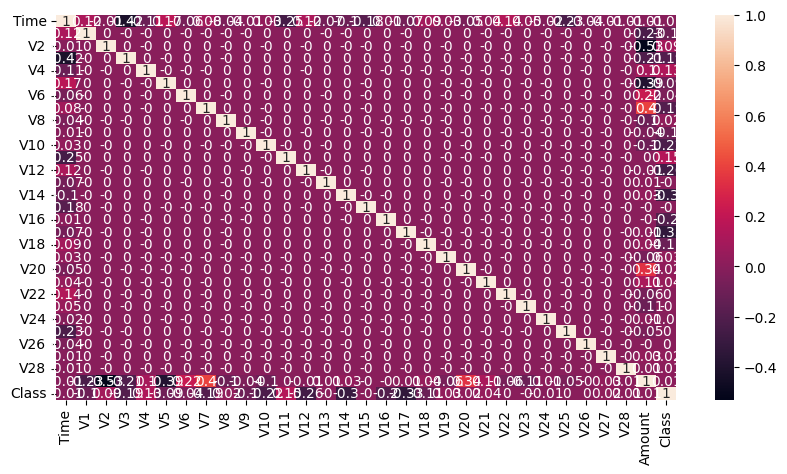

In [75]:
# let´s check if there are any features that are highly correlated
# looks like there are no particularly strong correlations between variables
df.drop('time_bin', axis=1, inplace=True)

corr_matrix = df.corr().round(2)

plt.figure(figsize = (10,5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [76]:
df_downasampled = pd.concat([df[df['Class'] == 0].sample(492,random_state=42), df[df['Class'] == 1]])
df_downasampled['Class'].value_counts()

Class
0    492
1    492
Name: count, dtype: int64

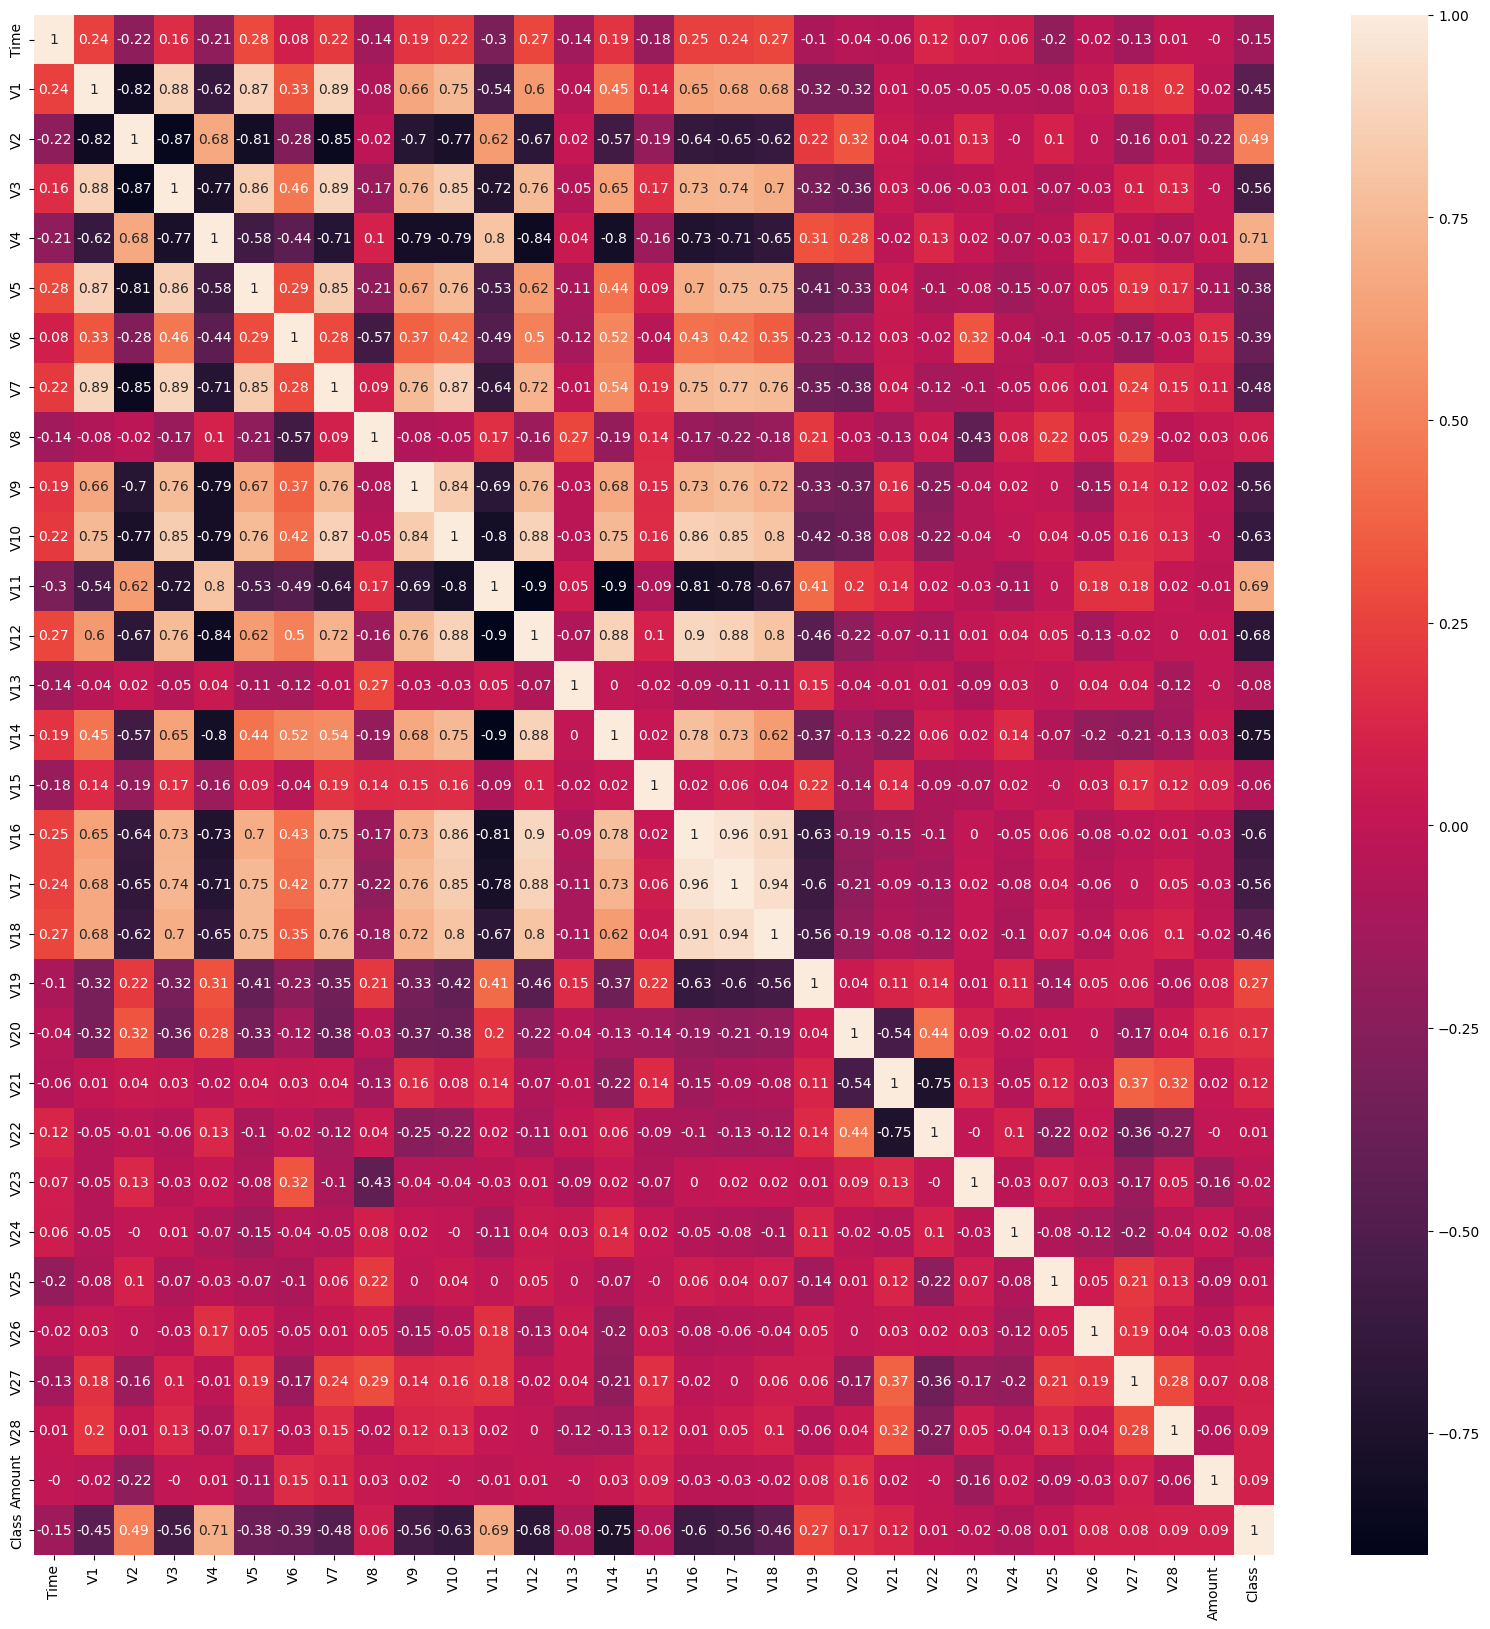

In [77]:
# having downsampled the dataset, we can better see the correlation between features because fraud cases are more visible
# we will only use downsampling for analysis, not for modeling

corr_matrix = df_downasampled.corr().round(2)

plt.figure(figsize = (20,20))
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Conclusions:
## Features with highest positive corr to fraud are 2, 4, 11, 19
## Features with highest negative corr to fraud are 3, 9, 10, 12, 14, 17, 18, 20

Correlation might not be the best when we have a binary variable and continuous feature. Let´s try doing t-test


In [78]:
not_fraud = df_downasampled[df_downasampled['Class'] == 0]
fraud = df_downasampled[df_downasampled['Class'] == 1]

train_cols = [col for col in df_downasampled.columns if col != 'Class'] # choosing all continuous columns except target

# Run t-test for each feature

p_values = []

for c in train_cols:
    p = ttest_ind(not_fraud[c], fraud[c]).pvalue
    p_values.append({'variable': c, 'p_value': p})

p_values_df = pd.DataFrame(p_values)
p_values_df

,variable,p_value
0,Time,2.625793e-06
1,V1,2.744289e-49
2,V2,4.352535e-61
3,V3,7.593596e-84
4,V4,2.446196e-153
5,V5,1.383982e-35
6,V6,5.967952e-37
7,V7,3.038744e-57
8,V8,7.286013e-02
9,V9,3.626276e-82


In [79]:
# ok, here I treid to exclude the variables that we not relevant but seems like every variable is valuable here

relevant_p_values = p_values_df[p_values_df['p_value']< 0.05]

relevant_p_values

,variable,p_value
0,Time,2.625793e-06
1,V1,2.744289e-49
2,V2,4.352535e-61
3,V3,7.593596e-84
4,V4,2.446196e-153
5,V5,1.383982e-35
6,V6,5.967952e-37
7,V7,3.038744e-57
9,V9,3.626276e-82
10,V10,3.318940e-109


# Modeling

First lets try a simple model (Logistic Regression) and let it handle the imbalanced class

In [80]:
# split target and features

# sorting df by time to later apply TimeSeries CV
df = df.sort_values(by='Time')


X = df.drop(['Time','Class'], axis=1)  # features
y = df["Class"]               # target

# split into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25, random_state=42)

#check sample size

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(213605, 29) (71202, 29) (213605,) (71202,)


In [81]:
# With StandardScaler we need to bring different numerical variables to comparable scales before ingesting it into the model

std = StandardScaler()
std = std.fit(X_train)

X_train = std.transform(X_train)
X_test = std.transform(X_test)

Logistic Regression

In [82]:
# here we´ll initialize the Time Serires Cross Validation

tscv = TimeSeriesSplit(n_splits=10)
filtered_splits = []

for i, (train_idx, val_idx) in enumerate(tscv.split(X_train), start=1):
    y_val = y_train.iloc[val_idx]
    positives = (y_val == 1).sum()
    
    if positives > 0:
        filtered_splits.append((train_idx, val_idx))
        print(f"✅ Fold {i} kept: Positives = {positives}")
    else:
        print(f"❌ Fold {i} skipped: Positives = {positives}")


✅ Fold 1 kept: Positives = 18
✅ Fold 2 kept: Positives = 57
✅ Fold 3 kept: Positives = 30
✅ Fold 4 kept: Positives = 32
✅ Fold 5 kept: Positives = 22
✅ Fold 6 kept: Positives = 19
✅ Fold 7 kept: Positives = 87
✅ Fold 8 kept: Positives = 11
✅ Fold 9 kept: Positives = 20
✅ Fold 10 kept: Positives = 17


Logistic Regression with Grid search

In [83]:

pipe = Pipeline([
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {'clf__C':[0.001,0.01,0.1],'clf__class_weight':[None,'balanced']}
search_lr = GridSearchCV(pipe, param_grid, cv=filtered_splits, scoring='average_precision', n_jobs=-1)
search_lr.fit(X_train, y_train)

# Best parameters and best score
print("Best PR AUC (mean CV):", search_lr.best_score_)
print("Best parameters:", search_lr.best_params_)

# Average precision on the full training set with the best model
y_proba = search_lr.best_estimator_.predict_proba(X_train)[:, 1]
pr_auc_full = average_precision_score(y_train, y_proba)
print("PR AUC on full training set:", pr_auc_full)


Best PR AUC (mean CV): 0.7121951257219565
Best parameters: {'clf__C': 0.01, 'clf__class_weight': None}
PR AUC on full training set: 0.7375715486698476


In [84]:

df = pd.read_csv('/Users/victoriayuzova/Data-Science-Projects/Fraud Detection/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [85]:

df = pd.read_csv('/Users/victoriayuzova/Data-Science-Projects/Fraud Detection/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [86]:

df = pd.read_csv('/Users/victoriayuzova/Data-Science-Projects/Fraud Detection/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Random Forest with Grid Search

In [87]:
pipe = Pipeline([
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [5, 7],
    'clf__max_features': ['sqrt'],
    'clf__criterion': ['gini']
}

search_rf = GridSearchCV(
    pipe, param_grid, cv=filtered_splits,
    scoring='average_precision', n_jobs=-1
)
search_rf.fit(X_train, y_train)

print("Best PR AUC (mean CV):", search_rf.best_score_)
print("Best parameters:", search_rf.best_params_)

y_proba = search_rf.best_estimator_.predict_proba(X_train)[:, 1]
pr_auc_full = average_precision_score(y_train, y_proba)
print("PR AUC on full training set:", pr_auc_full)


/Users/victoriayuzova/Data-Science-Projects/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best PR AUC (mean CV): 0.7827649920669145
Best parameters: {'clf__criterion': 'gini', 'clf__max_depth': 7, 'clf__max_features': 'sqrt', 'clf__n_estimators': 300}
PR AUC on full training set: 0.917822647590702


Gradient Boosting with Grid Search

In [88]:
pipe = Pipeline([
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', GradientBoostingClassifier(random_state=42))
])

param_grid = {
    'clf__learning_rate': [0.1],                
    'clf__n_estimators': [100],                 
    'clf__max_depth': [5],                      
    
}

search_gb = GridSearchCV(
    pipe, param_grid, cv=filtered_splits,
    scoring='average_precision', n_jobs=-1, return_train_score=False
)
search_gb.fit(X_train, y_train)

print("Best PR AUC (mean CV):", search_gb.best_score_)
print("Best parameters:", search_gb.best_params_)

y_proba = search_gb.best_estimator_.predict_proba(X_train)[:, 1]
print("PR AUC on full training set:", average_precision_score(y_train, y_proba))


Best PR AUC (mean CV): 0.7451044220684726
Best parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100}
PR AUC on full training set: 0.8982207057708472


# Compare the models

In [89]:
X_test

array([[ 1.16621077, -1.0393723 , -0.197021  , ...,  0.15944215,
        -0.11349282, -0.15365366],
       [-1.27849038, -0.24099772, -1.09816043, ..., -0.00394465,
         0.97980419, -0.19386686],
       [ 1.18158731, -0.98087512, -1.14951298, ...,  0.10434125,
        -0.23008488, -0.28233592],
       ...,
       [-0.08313924,  0.32793218,  0.30904475, ...,  0.27196906,
         0.31442751, -0.32254912],
       [ 1.04627622, -0.18123555, -2.38050496, ...,  0.00967781,
        -0.08706663, -0.08979509],
       [-0.23632761, -0.11296554,  0.30960764, ..., -0.00758799,
         0.03608179,  0.50986424]], shape=(71202, 29))

LR AP: Train 0.712 || Test 0.745
RF AP: Train 0.783 || Test 0.804
GB AP: Train 0.745 || Test 0.783


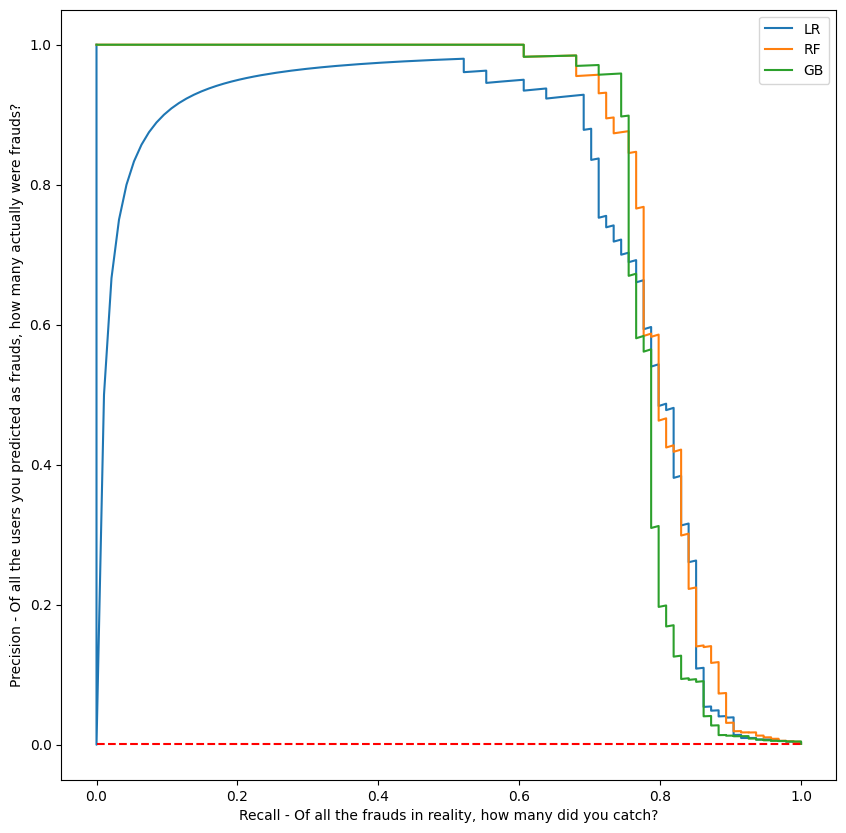

In [90]:
# Lets visualize precision recall curve for all three models

plt.figure(figsize=(10,10))

# Logistic Regression
prec, rec, _ = precision_recall_curve(y_test, search_lr.predict_proba(X_test)[:, 1])
ap_lr_test = average_precision_score(y_test, search_lr.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Random Forest
prec, rec, _ = precision_recall_curve(y_test, search_rf.predict_proba(X_test)[:, 1])
ap_rf_test = average_precision_score(y_test, search_rf.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Gradient Boosting
prec, rec, _ = precision_recall_curve(y_test, search_gb.predict_proba(X_test)[:, 1])
ap_gb_test = average_precision_score(y_test, search_gb.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

plt.xlabel("Recall - Of all the frauds in reality, how many did you catch?")
plt.ylabel("Precision - Of all the users you predicted as frauds, how many actually were frauds?")
plt.legend(["LR", "RF", "GB"])

# Print train/test AP
print("LR AP: Train {:.3f} || Test {:.3f}".format(search_lr.best_score_, ap_lr_test))
print("RF AP: Train {:.3f} || Test {:.3f}".format(search_rf.best_score_, ap_rf_test))
print("GB AP: Train {:.3f} || Test {:.3f}".format(search_gb.best_score_, ap_gb_test))
plt.hlines(y=0.001727, xmin=0, xmax=1, colors='red', linestyles='dashed', label='Baseline (random)')


# looks like the test is pretty different from what we´ve seen in train (not very good?)
# so here GB shows to be the best model; we can play with the threasholds and find optimal balance between precision and recall:


Threshold for ≥ 0.70 recall: 0.988
Recall:    0.702
Precision: 0.971

Business Impact:
Total frauds in test set: 94
Frauds caught: 66 (70.2%)
Frauds missed: 28 (29.8%)
Legitimate users flagged: 2 (0.00% of all legitimate users)
Legitimate users correctly cleared: 71106


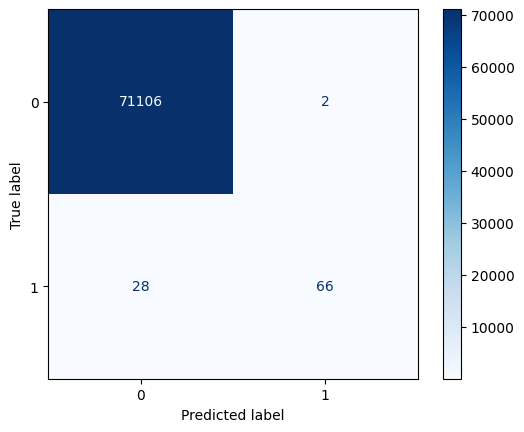

In [91]:
# Here I want to see if I settle for catching 90% of all frauds, how many legitimate users will be wrongly flagged
# I think the final decision could depend on company's budget for false positives vs missed frauds

# Set your target recall (e.g., catch 70% of all frauds)
target_recall = 0.7

# Get predicted probabilities
y_probs = search_gb.predict_proba(X_test)[:, 1]

# Get precision-recall-thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Find the first index where recall >= target (excluding the last point)
valid_idx = np.where(recalls[:-1] >= target_recall)[0]

if len(valid_idx) > 0:
    idx = valid_idx[-1]  # Take the last one to get highest precision at target recall
    threshold = thresholds[idx]
    
    y_pred = (y_probs >= threshold).astype(int)

    cm_gb = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
    disp.plot(cmap='Blues')

    print(f"Threshold for ≥ {target_recall:.2f} recall: {threshold:.3f}")
    print(f"Recall:    {recalls[idx]:.3f}")
    print(f"Precision: {precisions[idx]:.3f}")
    
    # Business impact analysis
    tn, fp, fn, tp = cm_gb.ravel()
    total_frauds = tp + fn
    total_legitimate = tn + fp
    
    print(f"\nBusiness Impact:")
    print(f"Total frauds in test set: {total_frauds}")
    print(f"Frauds caught: {tp} ({tp/total_frauds:.1%})")
    print(f"Frauds missed: {fn} ({fn/total_frauds:.1%})")
    print(f"Legitimate users flagged: {fp} ({fp/total_legitimate:.2%} of all legitimate users)")
    print(f"Legitimate users correctly cleared: {tn}")
    
else:
    print(f"No threshold found with recall ≥ {target_recall}")

Threshold for ≥ 0.90 precision: 0.962
Precision: 0.909
Recall:    0.745


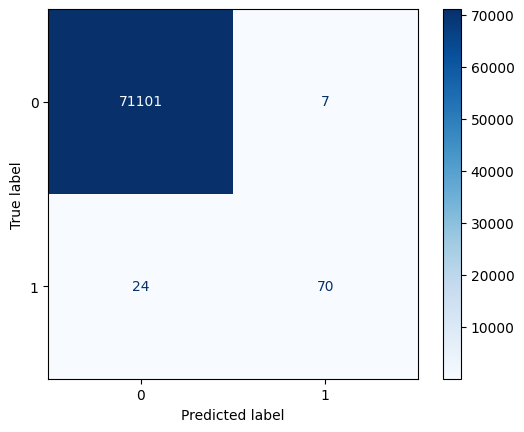

In [92]:

# Here I want to see if I settle for getting 60% of predicted fraud right; how many users will be actually hit wrongly and how many fraudsters we willl miss
# I think the final desicion could depend on company´s budget for chargebacks  - I would propose missing 10% of fraudulent users (0.885 recall) and being wrong with 50% of predictions; 
# since these are not that many users in relation to our total population, we are not losing that much
# In exchange if we compromised on blocking wrong people (0.1 precision) the win is not that big (?), only 5 additional fraudulent users  or so caught 


# Set your target precision
target_precision = 0.9

# Get predicted probabilities
y_probs = search_gb.predict_proba(X_test)[:, 1]

# Get precision-recall-thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Find the first index where precision >= target (excluding the last point)
valid_idx = np.where(precisions[:-1] >= target_precision)[0]

if len(valid_idx) > 0:
    idx = valid_idx[0]
    threshold = thresholds[idx]
    
    y_pred = (y_probs >= threshold).astype(int)

    cm_gb = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
    disp.plot(cmap='Blues')

    print(f"Threshold for ≥ {target_precision:.2f} precision: {threshold:.3f}")
    print(f"Precision: {precisions[idx]:.3f}")
    print(f"Recall:    {recalls[idx]:.3f}")
else:
    print(f"No threshold found with precision ≥ {target_precision}")


# Debug the models

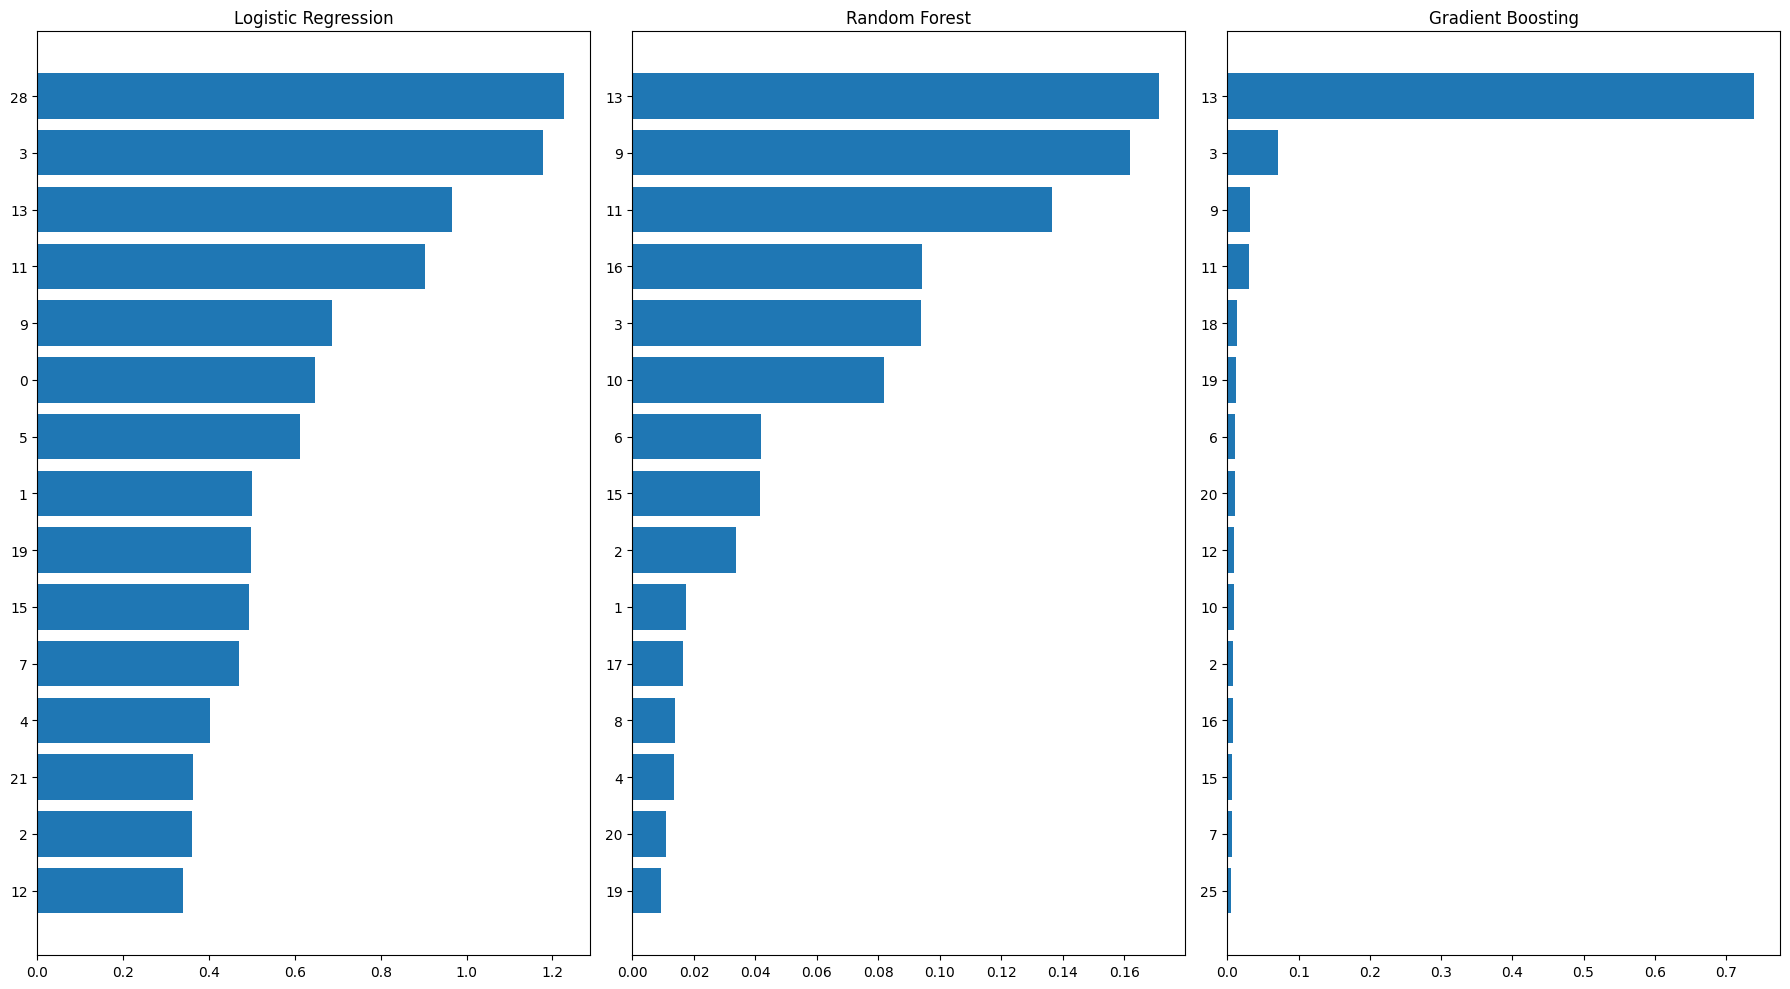

In [93]:
# first lets check feature importance for all three models

lr_imp = np.abs(search_lr.best_estimator_['clf'].coef_).flatten()
rf_imp = search_rf.best_estimator_['clf'].feature_importances_
gb_imp = search_gb.best_estimator_['clf'].feature_importances_

# Helper to get sorted top N indices for a model
def top_features(imp, n=15):
    idx = np.argsort(imp)[-n:][::-1]
    return idx, imp[idx]

# Top 15 features for each model (sorted descending)
lr_idx, lr_vals = top_features(lr_imp)
rf_idx, rf_vals = top_features(rf_imp)
gb_idx, gb_vals = top_features(gb_imp)

# Plot
plt.figure(figsize=(18, 10))

plt.subplot(1, 3, 1)
plt.barh(range(15), lr_vals[::-1])
plt.yticks(range(15), lr_idx[::-1])
plt.title("Logistic Regression")

plt.subplot(1, 3, 2)
plt.barh(range(15), rf_vals[::-1])
plt.yticks(range(15), rf_idx[::-1])
plt.title("Random Forest")

plt.subplot(1, 3, 3)
plt.barh(range(15), gb_vals[::-1])
plt.yticks(range(15), gb_idx[::-1])
plt.title("Gradient Boosting")

plt.tight_layout()
plt.show()


# Note from heatmap:
## Features with highest positive corr to fraud are 2, 4, 11, 19
## Features with highest negative corr to fraud are 3, 9, 10, 12, 14, 17, 18, 20



# Notes on feature importance:
# Features 13 never appeares as correlated to Fraud in the heatmap but we are seeing it in the feature importance in all three models




In [94]:
# Predict labels (0/1) for each model
y_pred_lr = search_lr.predict(X_test)
y_pred_rf = search_rf.predict(X_test)
y_pred_gb = search_gb.predict(X_test)

# Collect row index for comparison
row_ids = X_test.index if hasattr(X_test, "index") else np.arange(len(X_test))

# Identify false positives and false negatives
fp_lr = row_ids[(y_pred_lr == 1) & (y_test == 0)]
fn_lr = row_ids[(y_pred_lr == 0) & (y_test == 1)]

fp_rf = row_ids[(y_pred_rf == 1) & (y_test == 0)]
fn_rf = row_ids[(y_pred_rf == 0) & (y_test == 1)]

fp_gb = row_ids[(y_pred_gb == 1) & (y_test == 0)]
fn_gb = row_ids[(y_pred_gb == 0) & (y_test == 1)]


In [95]:
# Overlaps in false positives
print("FP overlaps:")
print("LR & RF:", len(set(fp_lr).intersection(fp_rf)))
print("LR & GB:", len(set(fp_lr).intersection(fp_gb)))
print("RF & GB:", len(set(fp_rf).intersection(fp_gb)))

# Overlaps in false negatives
print("\nFN overlaps:")
print("LR & RF:", len(set(fn_lr).intersection(fn_rf)))
print("LR & GB:", len(set(fn_lr).intersection(fn_gb)))
print("RF & GB:", len(set(fn_rf).intersection(fn_gb)))


FP overlaps:
LR & RF: 78
LR & GB: 82
RF & GB: 43

FN overlaps:
LR & RF: 11
LR & GB: 11
RF & GB: 16


In [96]:
# lets add predictions from all three models to the test set to analize the errors

X_test_df = pd.DataFrame(X_test).reset_index(drop=True)

y_test_series = pd.Series(y_test, name="true_label").reset_index(drop=True)
y_pred_lr_series = pd.Series(y_pred_lr, name="pred_lr")
y_pred_rf_series = pd.Series(y_pred_rf, name="pred_rf")
y_pred_gb_series = pd.Series(y_pred_gb, name="pred_gb")

df_all_preds = pd.concat([
    X_test_df,
    y_test_series,
    y_pred_lr_series,
    y_pred_rf_series,
    y_pred_gb_series
], axis=1)

df_all_preds.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,true_label,pred_lr,pred_rf,pred_gb
0,1.166211,-1.039372,-0.197021,-1.182509,-1.213835,0.082741,-1.426677,0.057258,-0.879810,1.455480,...,-0.805311,-1.063132,-0.508851,0.159442,-0.113493,-0.153654,0,0,0,0
1,-1.278490,-0.240998,-1.098160,0.561564,1.702900,-1.620741,1.250177,-0.648734,0.293988,-0.877847,...,-0.597659,1.158913,-0.658160,-0.003945,0.979804,-0.193867,0,1,0,0
2,1.181587,-0.980875,-1.149513,-1.459612,-0.100980,1.080162,-1.156831,0.360447,-1.183890,1.499880,...,-1.637240,-0.765041,-0.166067,0.104341,-0.230085,-0.282336,0,0,0,0
3,0.031211,0.473866,-0.527896,-0.952129,0.565789,0.145630,0.618088,0.036559,0.064360,-1.391667,...,-2.659551,-1.832425,1.705938,-0.207963,0.138991,-0.001246,0,0,0,0
4,1.162321,-0.532304,-1.464491,-0.708559,-0.050078,-0.590640,-0.130009,-0.151450,-0.558244,0.915652,...,1.191658,0.440767,-0.101016,-0.200547,-0.244571,-0.194028,0,0,0,0


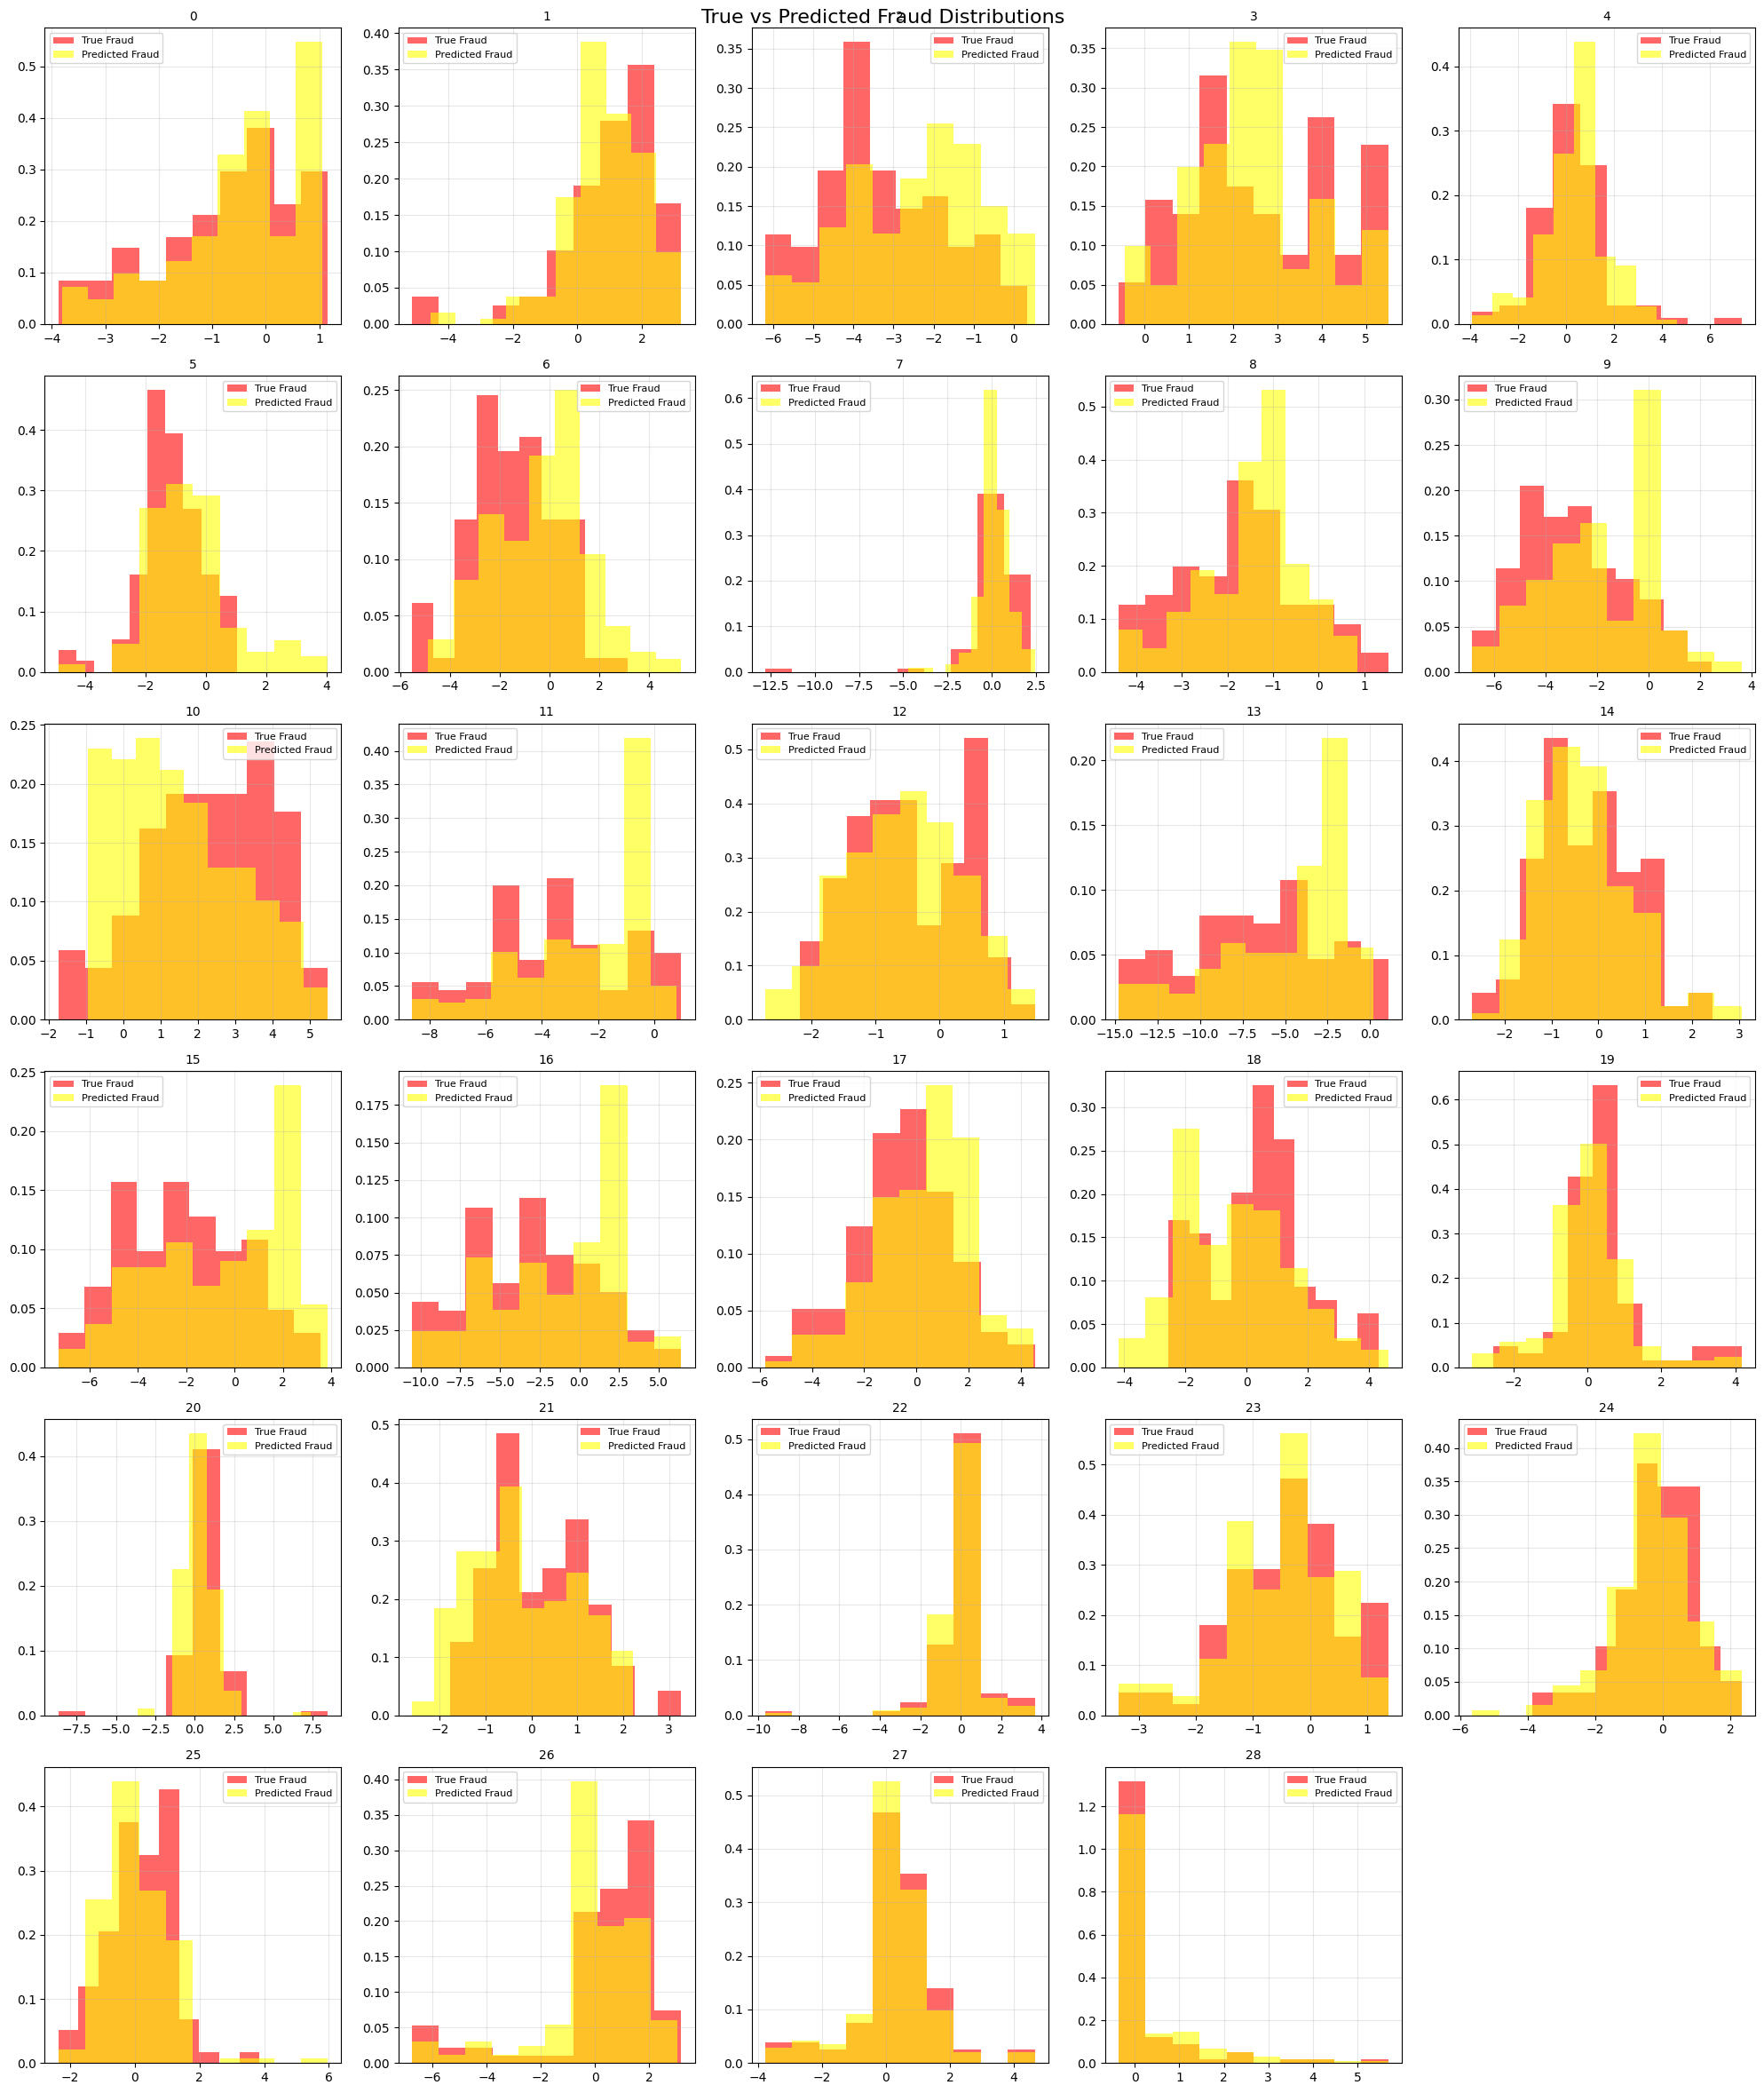

In [ ]:
exclude = ['true_label', 'pred_gb', 'error_type_gb', 'Class','pred_lr','pred_rf']
features = [col for col in df_all_preds.columns if col not in exclude]

# Calculate grid dimensions
n_cols = 5  # Number of columns in grid
n_rows = int(np.ceil(len(features) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
fig.suptitle('True vs Predicted Fraud Gradient Boosting', fontsize=16)

# Flatten axes for easy indexing
axes_flat = axes.flatten()

for i, col in enumerate(features):
    ax = axes_flat[i]
    
    # Plot histograms
    ax.hist(df_all_preds[df_all_preds['true_label'] == 1][col], 
            bins=10, alpha=0.6, label='True Fraud', color='red', density=True)
    ax.hist(df_all_preds[df_all_preds['pred_gb'] == 1][col], 
            bins=10, alpha=0.6, label='Predicted Fraud', color='yellow', density=True)
    
    ax.set_title(col, fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for i in range(len(features), len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

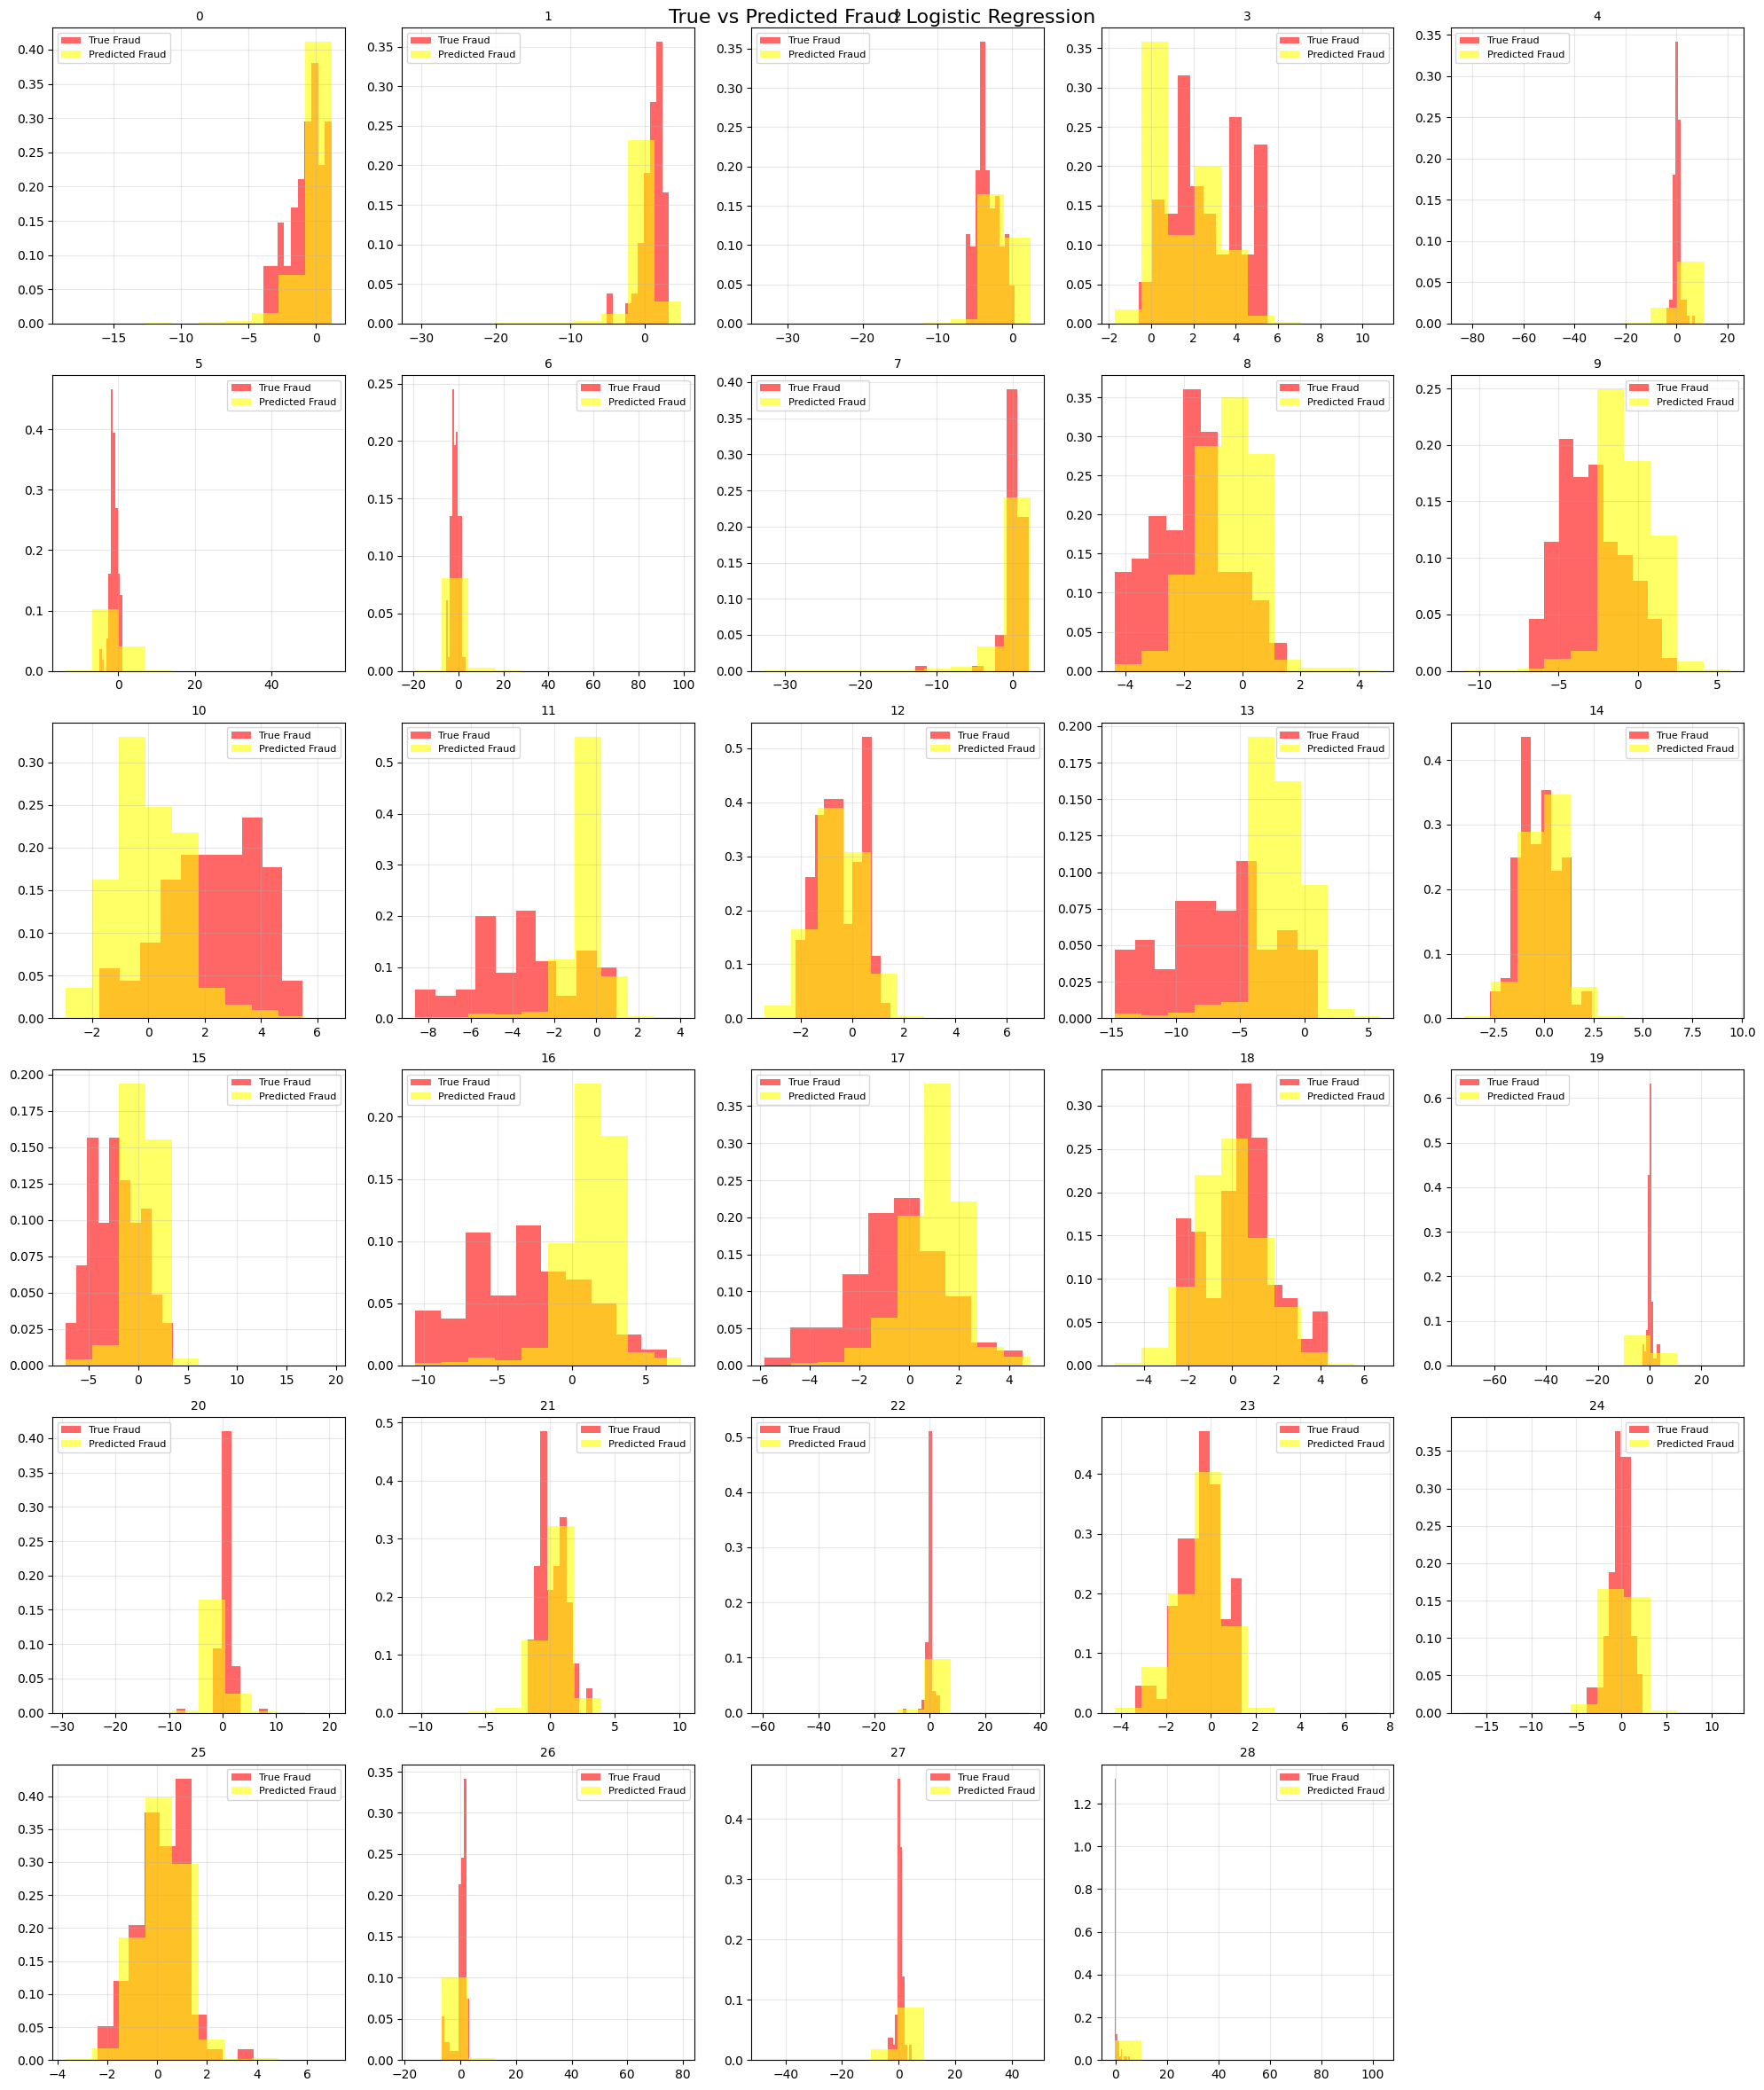

In [176]:
exclude = ['true_label', 'pred_gb', 'error_type_gb', 'Class','pred_lr','pred_rf']
features = [col for col in df_all_preds.columns if col not in exclude]

# Calculate grid dimensions
n_cols = 5  # Number of columns in grid
n_rows = int(np.ceil(len(features) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
fig.suptitle('True vs Predicted Fraud Logistic Regression', fontsize=16)

# Flatten axes for easy indexing
axes_flat = axes.flatten()

for i, col in enumerate(features):
    ax = axes_flat[i]
    
    # Plot histograms
    ax.hist(df_all_preds[df_all_preds['true_label'] == 1][col], 
            bins=10, alpha=0.6, label='True Fraud', color='red', density=True)
    ax.hist(df_all_preds[df_all_preds['pred_lr'] == 1][col], 
            bins=10, alpha=0.6, label='Predicted Fraud', color='yellow', density=True)
    
    ax.set_title(col, fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for i in range(len(features), len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

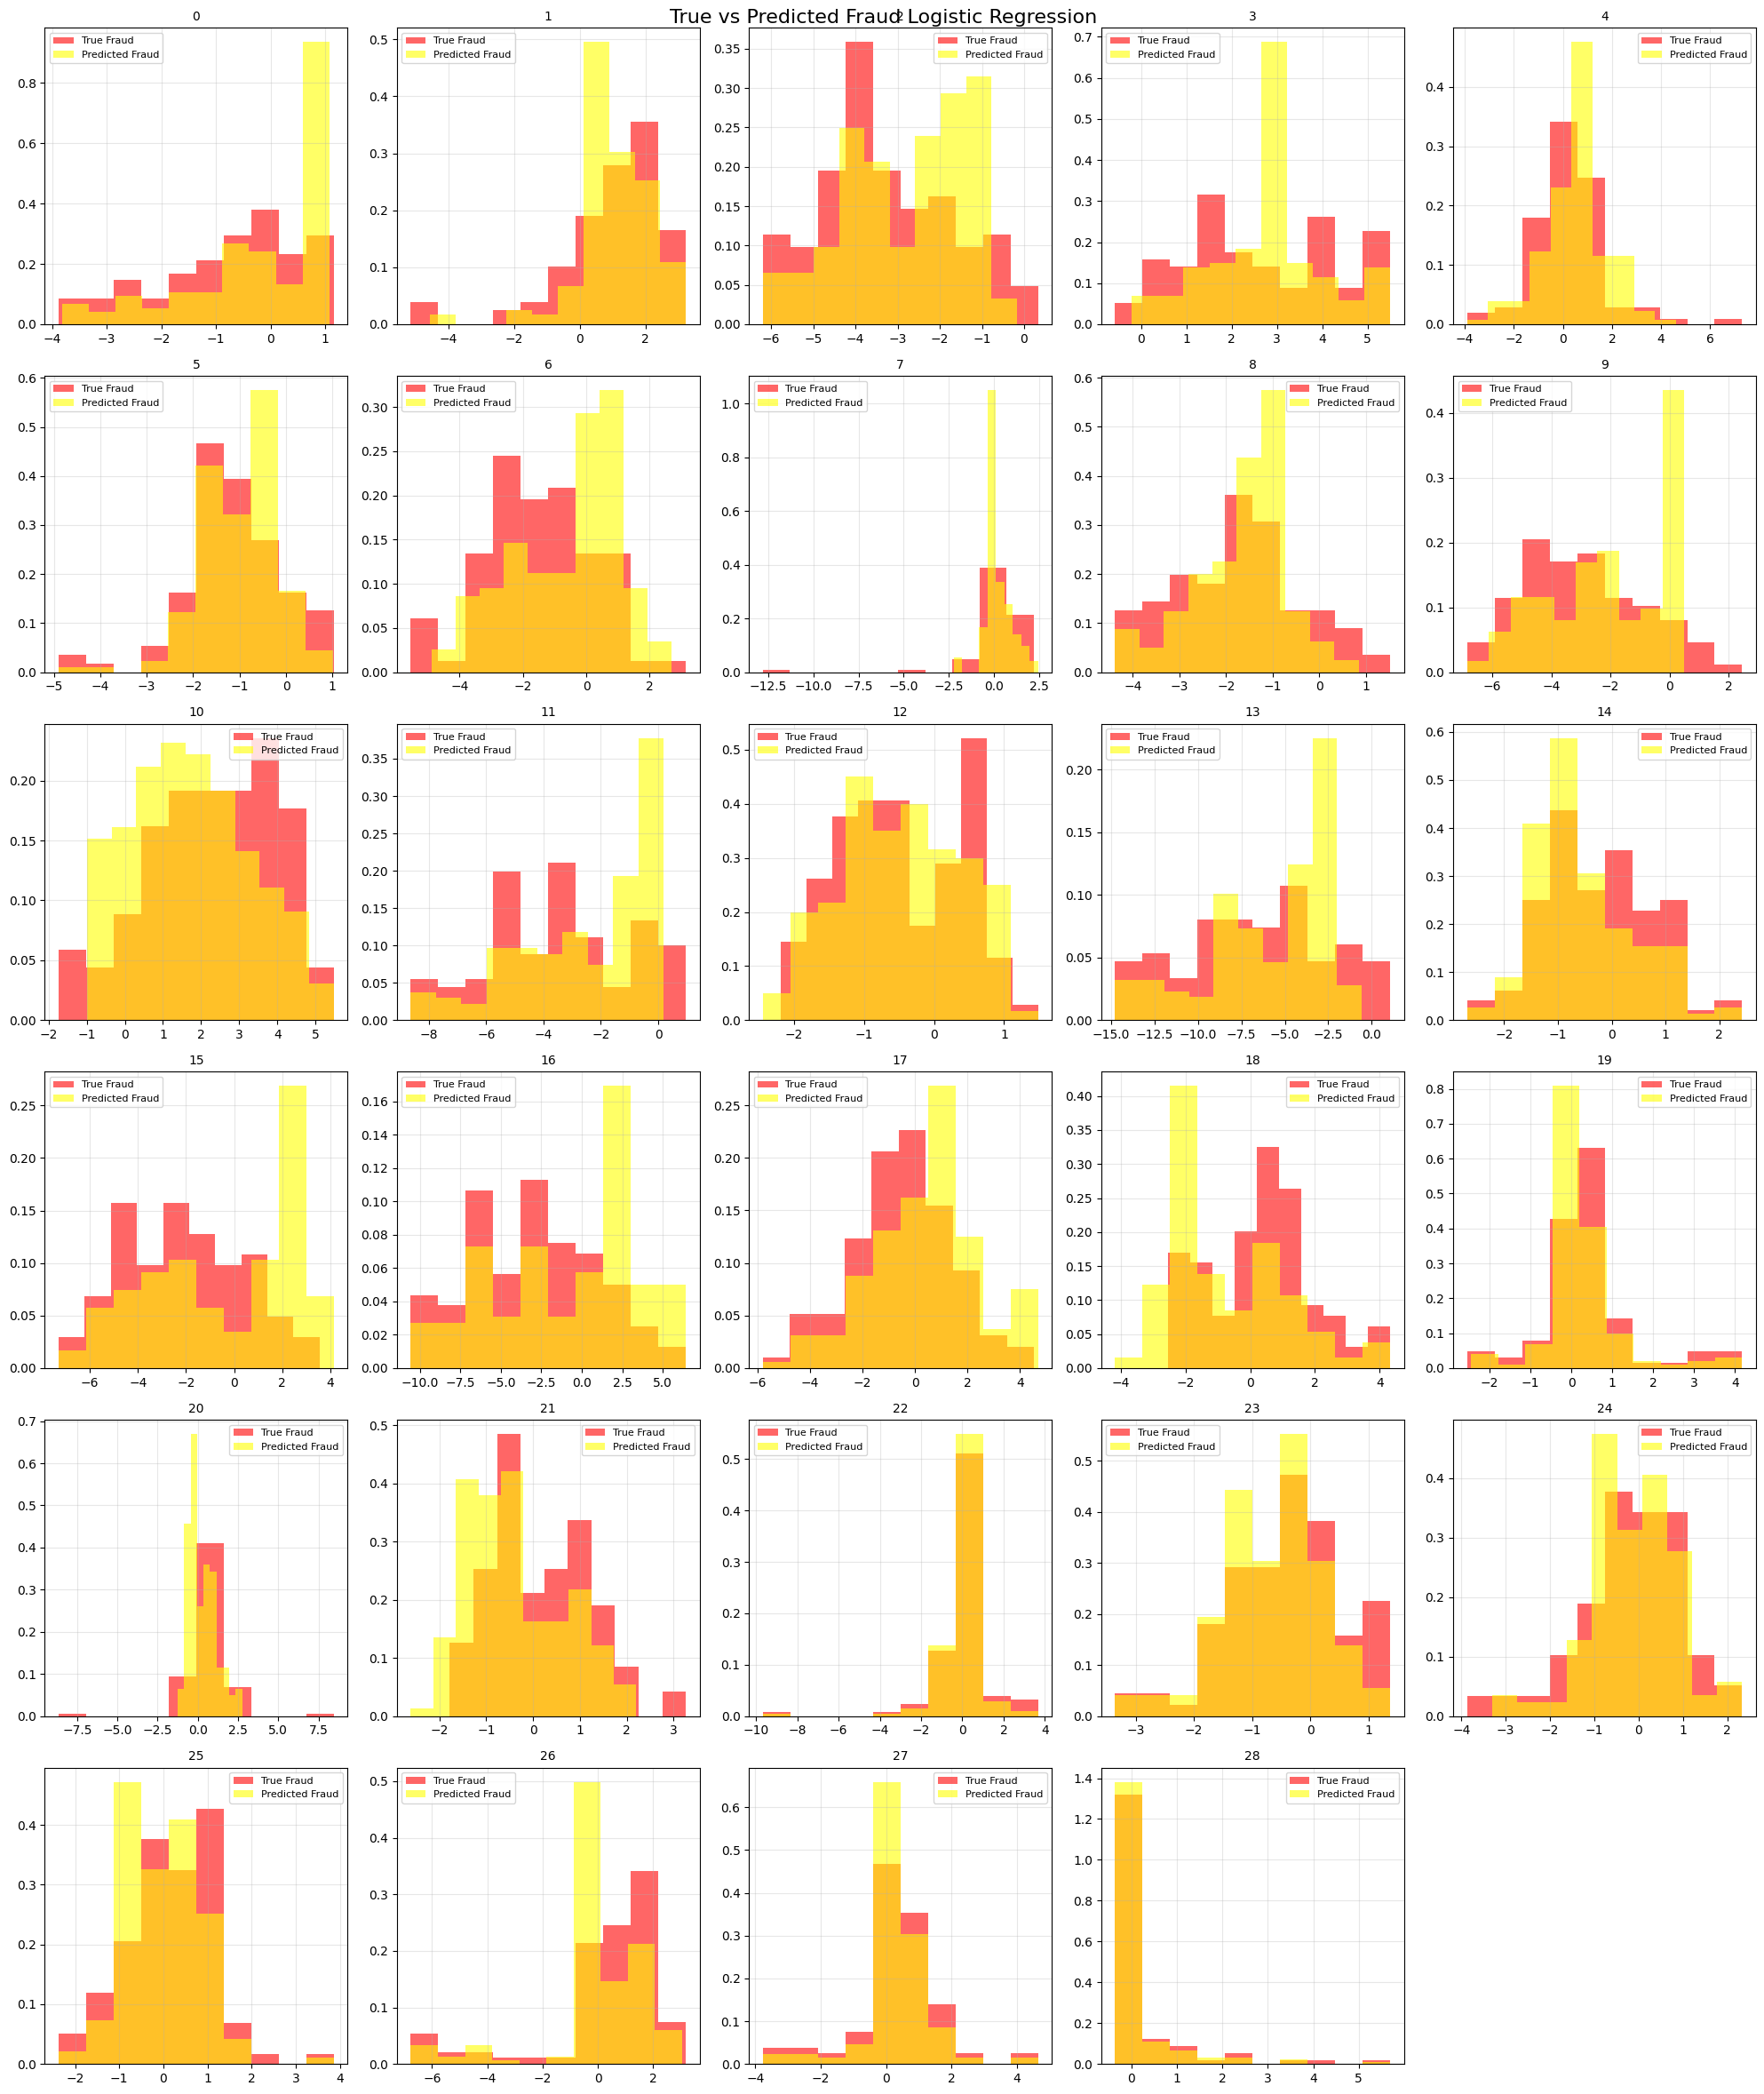

In [177]:
exclude = ['true_label', 'pred_gb', 'error_type_gb', 'Class','pred_lr','pred_rf']
features = [col for col in df_all_preds.columns if col not in exclude]

# Calculate grid dimensions
n_cols = 5  # Number of columns in grid
n_rows = int(np.ceil(len(features) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
fig.suptitle('True vs Predicted Fraud Logistic Regression', fontsize=16)

# Flatten axes for easy indexing
axes_flat = axes.flatten()

for i, col in enumerate(features):
    ax = axes_flat[i]
    
    # Plot histograms
    ax.hist(df_all_preds[df_all_preds['true_label'] == 1][col], 
            bins=10, alpha=0.6, label='True Fraud', color='red', density=True)
    ax.hist(df_all_preds[df_all_preds['pred_rf'] == 1][col], 
            bins=10, alpha=0.6, label='Predicted Fraud', color='yellow', density=True)
    
    ax.set_title(col, fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for i in range(len(features), len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

In [128]:
int(np.ceil(len(feature_columns) / n_cols))


1

### Deep Dive GB Results

In [97]:

def classify_error(row):
    if row['true_label'] == 1 and row['pred_gb'] == 1:
        return "TP"
    elif row['true_label'] == 0 and row['pred_gb'] == 1:
        return "FP"
    elif row['true_label'] == 1 and row['pred_gb'] == 0:
        return "FN"
    else:
        return "TN"

df_all_preds["error_type_gb"] = df_all_preds.apply(classify_error, axis=1)


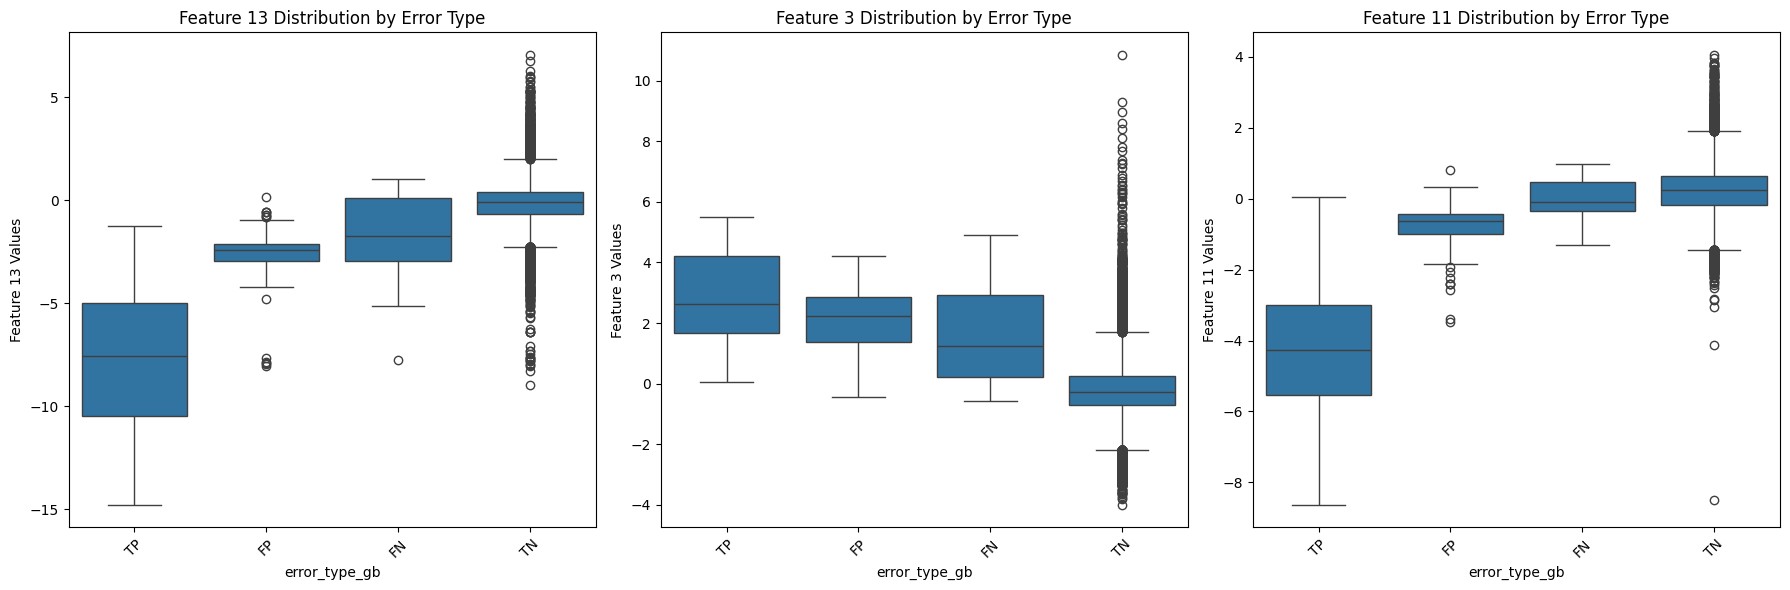

In [98]:
# Define features to plot
features_to_plot = [13, 3, 11]
feature_names = ["Feature 13", "Feature 3", "Feature 11"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through features
for i, (feature, name) in enumerate(zip(features_to_plot, feature_names)):
    sns.boxplot(data=df_all_preds, x="error_type_gb", y=feature, 
                order=["TP", "FP", "FN", "TN"], ax=axes[i])
    axes[i].set_title(f"{name} Distribution by Error Type")
    axes[i].set_ylabel(f"{name} Values")
    
    # Rotate x-axis labels if needed
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

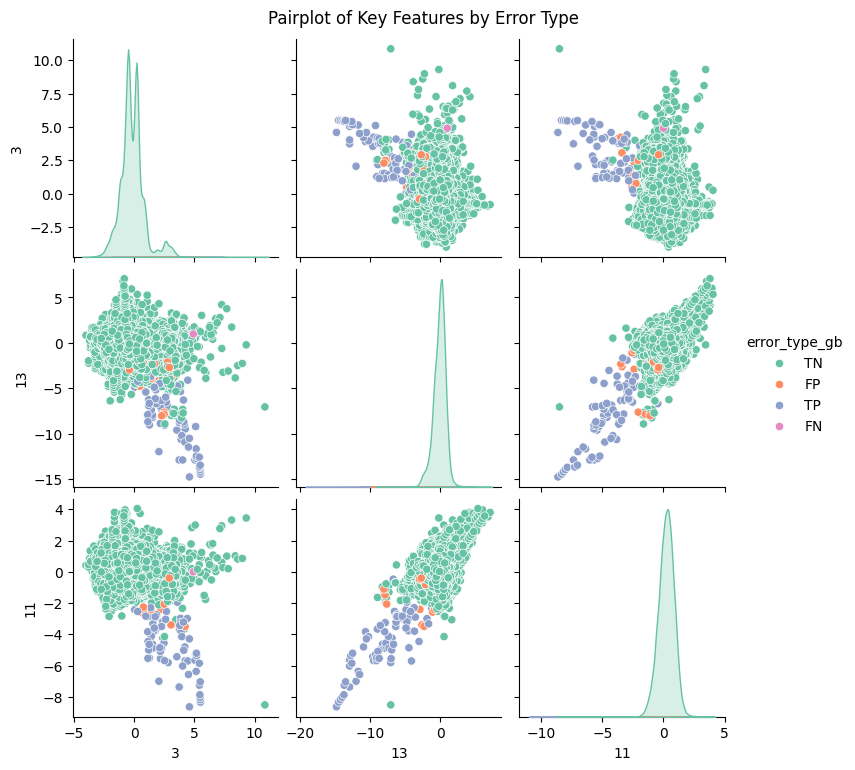

In [99]:
sns.pairplot(df_all_preds[[3, 13, 11, 'error_type_gb']], hue="error_type_gb", palette="Set2")
plt.suptitle("Pairplot of Key Features by Error Type", y=1.02)
plt.show()

In [100]:
# Do false negatives have tight or different values?
# Do false positives overlap with true positives?
# Is there a range where mistakes consistently happen?


df_all_preds[df_all_preds["error_type_gb"]=="FN"].describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
0,20.0,0.01,1.36,-3.88,-0.06,0.22,1.02,1.16
1,20.0,0.03,1.55,-5.14,-0.46,0.45,0.82,1.99
2,20.0,-1.36,1.02,-3.60,-1.93,-1.45,-0.64,0.33
3,20.0,1.46,1.55,-0.58,0.21,1.23,2.94,4.91
4,20.0,1.16,1.64,-0.96,0.56,1.01,1.39,7.30
5,20.0,-0.55,1.12,-4.42,-0.95,-0.41,-0.07,1.03
6,20.0,0.06,1.99,-5.54,-0.01,0.56,0.99,3.14
7,20.0,-1.16,2.99,-12.81,-0.57,-0.21,-0.10,0.59
8,20.0,-0.32,1.05,-1.86,-1.38,-0.15,0.43,1.52
9,20.0,-0.07,1.03,-1.47,-0.83,-0.24,0.40,2.46


In [101]:
df_all_preds[df_all_preds["error_type_gb"]=="FP"].describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
0,95.0,-0.10,1.13,-3.69,-0.57,-0.08,0.95,1.05
1,95.0,0.54,0.87,-2.54,0.04,0.60,1.10,2.46
2,95.0,-1.32,1.02,-4.57,-1.88,-1.38,-0.63,0.52
3,95.0,2.04,1.04,-0.45,1.37,2.23,2.88,4.22
4,95.0,0.70,1.28,-3.29,0.34,0.74,1.22,3.07
5,95.0,0.14,1.40,-1.99,-0.66,-0.22,0.89,4.05
6,95.0,0.74,1.54,-4.05,0.14,0.58,1.51,5.29
7,95.0,-0.14,0.87,-4.74,-0.39,-0.09,0.11,2.44
8,95.0,-0.96,0.77,-2.90,-1.31,-1.06,-0.62,0.78
9,95.0,-0.30,1.29,-3.12,-1.17,0.11,0.33,3.61


### Review of overlapping errors

In [102]:
# create dataframes for each error type that overlaps between different models

df_false_negatives = df_all_preds[(df_all_preds['true_label']==1) & 
             (df_all_preds['pred_lr']==0) &
            (df_all_preds['pred_rf']==0) & 
            (df_all_preds['pred_gb']==0)]

df_false_positives = df_all_preds[(df_all_preds['true_label']==0) & 
             (df_all_preds['pred_lr']==1) &
            (df_all_preds['pred_rf']==1) & 
            (df_all_preds['pred_gb']==1)]

df_true_positives = df_all_preds[(df_all_preds['true_label']==1) & 
             (df_all_preds['pred_lr']==1) &
            (df_all_preds['pred_rf']==1) & 
            (df_all_preds['pred_gb']==1)]


df_true_negatives = df_all_preds[(df_all_preds['true_label']==0) & 
             (df_all_preds['pred_lr']==0) &
            (df_all_preds['pred_rf']==0) & 
            (df_all_preds['pred_gb']==0)]

In [103]:
df_false_positives.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,43.0,0.264230,1.203502,-3.694960,-0.190802,0.854362,1.019185,1.047904
1,43.0,0.792308,0.833596,-1.370462,0.478386,0.663679,0.941262,2.462238
2,43.0,-1.731910,0.838899,-4.565206,-1.957390,-1.446292,-1.295019,-0.171665
3,43.0,2.315321,0.971180,-0.205462,2.205579,2.801640,2.905325,3.171014
4,43.0,0.776424,1.192030,-2.952608,0.569583,0.802403,1.001809,2.678076
5,43.0,-0.647091,0.593206,-1.986026,-1.177726,-0.489269,-0.204038,0.284660
6,43.0,0.410845,1.379302,-4.051915,0.215475,0.417923,1.059754,2.687939
7,43.0,0.043650,0.611489,-0.636660,-0.194456,-0.056416,0.072360,2.436153
8,43.0,-1.145184,0.722898,-2.899527,-1.276124,-1.062619,-0.821865,0.597561
9,43.0,-0.624381,1.281164,-3.119540,-1.969031,0.211203,0.322984,0.504663


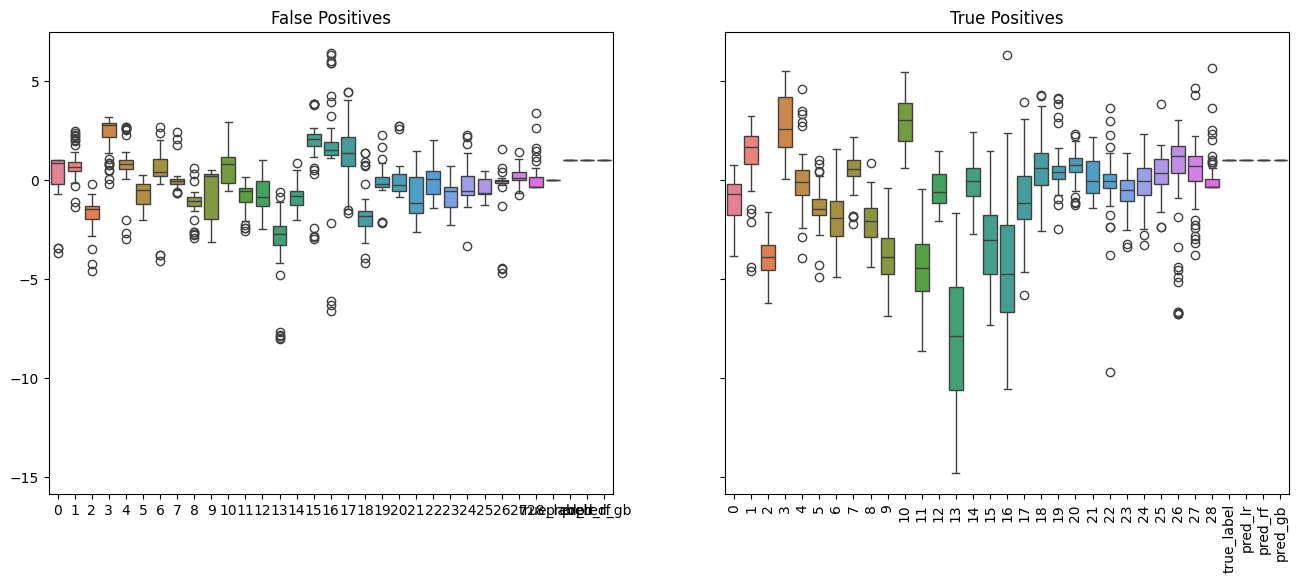

In [104]:
# Among TP, certain features have huge variability

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.boxplot(data=df_false_positives, ax=axes[0])
axes[0].set_title("False Positives")

sns.boxplot(data=df_true_positives, ax=axes[1])
axes[1].set_title("True Positives")


plt.xticks(rotation=90)
plt.show()

# Trying Ensemble Models

In [105]:
voting_hard = VotingClassifier(
    estimators=[
        ('lr', search_lr.best_estimator_),
        ('rf', search_rf.best_estimator_),
        ('gb', search_gb.best_estimator_)
    ],
    voting='hard'
)

voting_hard.fit(X_train, y_train)
y_pred_hard = voting_hard.predict(X_test)


In [106]:
voting_soft = VotingClassifier(
    estimators=[
        ('lr', search_lr.best_estimator_),
        ('rf', search_rf.best_estimator_),
        ('gb', search_gb.best_estimator_)
    ],
    voting='soft',
    weights=[1, 1, 2]  # optional: boost best model
)

voting_soft.fit(X_train, y_train)
y_prob_soft = voting_soft.predict_proba(X_test)[:, 1]
y_pred_soft = (y_prob_soft > 0.5).astype(int)  # set your own threshold


In [107]:
stacked = StackingClassifier(
    estimators=[
        ('lr', search_lr.best_estimator_),
        ('rf', search_rf.best_estimator_),
        ('gb', search_gb.best_estimator_)
    ],
    final_estimator=LogisticRegression(),
    passthrough=True  # includes original features
)

stacked.fit(X_train, y_train)
y_pred_stacked = stacked.predict(X_test)


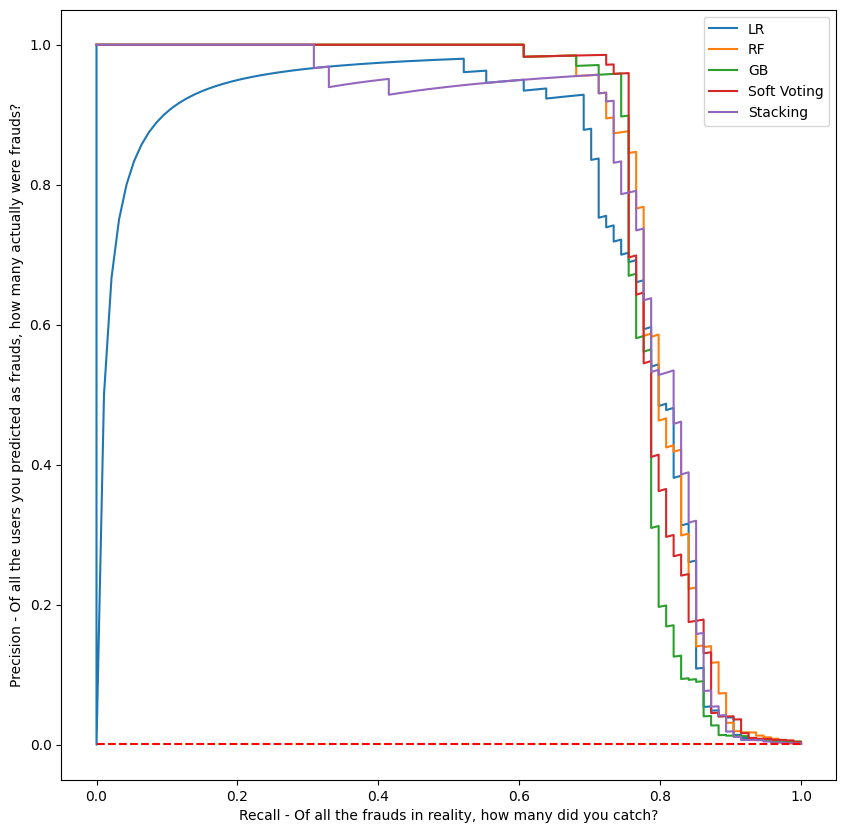

In [108]:
plt.figure(figsize=(10, 10))

# Logistic Regression
prec, rec, _ = precision_recall_curve(y_test, search_lr.predict_proba(X_test)[:, 1])
ap_lr_test = average_precision_score(y_test, search_lr.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Random Forest
prec, rec, _ = precision_recall_curve(y_test, search_rf.predict_proba(X_test)[:, 1])
ap_rf_test = average_precision_score(y_test, search_rf.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Gradient Boosting
prec, rec, _ = precision_recall_curve(y_test, search_gb.predict_proba(X_test)[:, 1])
ap_gb_test = average_precision_score(y_test, search_gb.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Soft Voting
prec, rec, _ = precision_recall_curve(y_test, voting_soft.predict_proba(X_test)[:, 1])
ap_soft_test = average_precision_score(y_test, voting_soft.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Stacking
prec, rec, _ = precision_recall_curve(y_test, stacked.predict_proba(X_test)[:, 1])
ap_stack_test = average_precision_score(y_test, stacked.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

plt.xlabel("Recall - Of all the frauds in reality, how many did you catch?")
plt.ylabel("Precision - Of all the users you predicted as frauds, how many actually were frauds?")
plt.legend(["LR", "RF", "GB", "Soft Voting", "Stacking"])
plt.hlines(y=0.001727, xmin=0, xmax=1, colors='red', linestyles='dashed', label='Baseline (random)')


In [109]:
print("LR AP: Test {:.3f}".format(ap_lr_test))
print("RF AP: Test {:.3f}".format(ap_rf_test))
print("GB AP: Test {:.3f}".format(ap_gb_test))
print("Soft Voting AP: Test {:.3f}".format(ap_soft_test))
print("Stacking AP: Test {:.3f}".format(ap_stack_test))


LR AP: Test 0.745
RF AP: Test 0.804
GB AP: Test 0.783
Soft Voting AP: Test 0.797
Stacking AP: Test 0.785


In [110]:
import eli5
from eli5.sklearn import PermutationImportance

# Make a small change to the code below to use in this problem. 
perm_gb = PermutationImportance(search_gb, random_state=1, scoring='average_precision').fit(X_test, y_test)

# uncomment the following line to visualize your results
eli5.show_weights(perm_gb, feature_names = X.columns.tolist())

Weight,Feature
0.1971 ± 0.0191,V14
0.1856 ± 0.0447,V4
0.1559 ± 0.0344,V12
0.1463 ± 0.0266,V11
0.1271 ± 0.0346,V10
0.0223 ± 0.0090,V3
0.0088 ± 0.0028,V1
0.0084 ± 0.0026,V16
0.0076 ± 0.0027,V5
0.0041 ± 0.0023,V7


In [111]:


# Make a small change to the code below to use in this problem. 
perm_lr = PermutationImportance(search_lr, random_state=1, scoring='average_precision').fit(X_test, y_test)

# uncomment the following line to visualize your results
eli5.show_weights(perm_lr, feature_names = X.columns.tolist())

Weight,Feature
0.3344 ± 0.0113,Amount
0.1615 ± 0.0085,V14
0.0656 ± 0.0205,V20
0.0554 ± 0.0059,V2
0.0452 ± 0.0033,V6
0.0415 ± 0.0078,V4
0.0409 ± 0.0044,V7
0.0318 ± 0.0075,V1
0.0313 ± 0.0032,V5
0.0312 ± 0.0057,V16


In [112]:

# Make a small change to the code below to use in this problem. 
perm_rf = PermutationImportance(search_rf, random_state=1, scoring='average_precision').fit(X_test, y_test)

# uncomment the following line to visualize your results
eli5.show_weights(perm_rf, feature_names = X.columns.tolist())

Weight,Feature
0.2994 ± 0.0525,V12
0.1868 ± 0.0217,V11
0.0991 ± 0.0278,V4
0.0718 ± 0.0345,V10
0.0498 ± 0.0074,V14
0.0496 ± 0.0104,V3
0.0125 ± 0.0041,V16
0.0086 ± 0.0026,V1
0.0047 ± 0.0051,V17
0.0024 ± 0.0030,V18


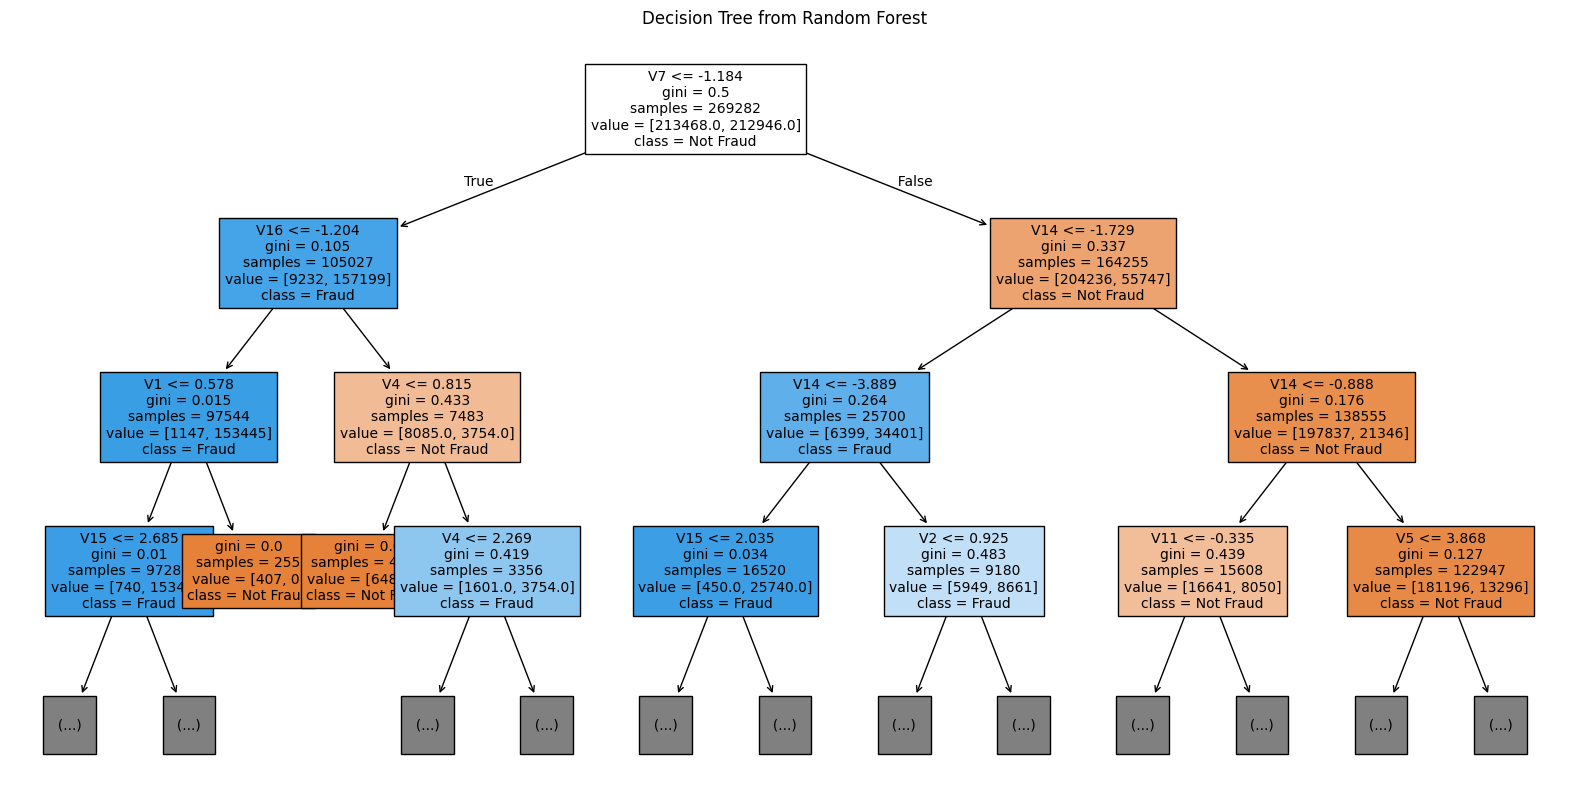

In [180]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get the classifier and first tree
rf_classifier = search_rf.best_estimator_['clf']
first_tree = rf_classifier.estimators_[0]

# Plot with matplotlib (no graphviz needed)
plt.figure(figsize=(20, 10))
plot_tree(first_tree, 
          feature_names=X.columns.tolist(),
          class_names=['Not Fraud', 'Fraud'],
          filled=True,
          max_depth=3,  # Limit depth for readability
          fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()


In [181]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Create and plot the data
disp1 = PartialDependenceDisplay.from_estimator(search_rf, X_test, y_test)
plt.show()


KeyboardInterrupt: 

In [ ]:
!pip install shap

In [ ]:
import shap

# Initialize the explainer with your best model
explainer = shap.Explainer(search_gb.best_estimator_)

# Calculate SHAP values for test set (or a sample if it's too large)
# For large datasets, use a sample to speed up computation
sample_size = 1000
X_test_sample = X_test.sample(n=min(sample_size, len(X_test)), random_state=42)

shap_values = explainer(X_test_sample)

In [ ]:
# Visualize Decision Trees from Random Forest

from sklearn import tree
import graphviz

# Access the RandomForestClassifier from the pipeline
rf_classifier = search_rf.best_estimator_['clf']

print(f"Random Forest has {rf_classifier.n_estimators} trees")
print(f"Visualizing tree at index 0 (you can change this to see different trees)")

# Visualize the first tree in the Random Forest (you can change the index to see different trees)
tree_index = 0  # Change this to visualize different trees (0 to n_estimators-1)

tree_graph = tree.export_graphviz(
    rf_classifier.estimators_[tree_index], 
    out_file=None, 
    feature_names=X.columns.tolist(),
    class_names=['Not Fraud', 'Fraud'],
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=3  # Limit depth for readability
)

graphviz.Source(tree_graph)


In [ ]:
# Alternative: Visualize multiple trees from the Random Forest

# Plot the first 3 trees side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i in range(min(3, rf_classifier.n_estimators)):
    tree_graph = tree.export_graphviz(
        rf_classifier.estimators_[i], 
        out_file=None, 
        feature_names=X.columns.tolist(),
        class_names=['Not Fraud', 'Fraud'],
        filled=True,
        rounded=True,
        special_characters=True,
        max_depth=2  # Keep it simple for multiple trees
    )
    
    # Note: This would show the DOT notation. For actual visualization, 
    # you'd need to render each one separately
    print(f"Tree {i} structure:")
    print(f"Max depth: {rf_classifier.estimators_[i].tree_.max_depth}")
    print(f"Number of leaves: {rf_classifier.estimators_[i].tree_.n_leaves}")
    print("---")

plt.tight_layout()
plt.show()


t t